# 🚑 A&E Breach Tracker (Jan–Mar 2025)
Using real NHS England data to identify the trusts with the highest number of patients breaching the 4-hour A&E target.  
Built with PySpark and Databricks.


This project uses real NHS England data to analyse A&E attendances and emergency admissions from **January to March 2025**.  
The goal is to uncover key insights about **4+ hour wait breaches**, spotlight the **highest-breaching trusts**, and communicate findings through clean, visual storytelling.

### ⚙️ Tech Stack
- **Platform**: Databricks Community Edition
- **Language**: PySpark
- **Data Source**: [NHS England A&E Monthly Data](https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/)
- **Visualisation**: Databricks display()

## Step 1: Load NHS A&E datasets  
We’re using the NHS England monthly A&E CSVs for:  
- February 2025  
- March 2025  
- April 2025  

Files were manually uploaded into Databricks via the UI, and read using PySpark.

In [0]:
# Loading the tables via Spark SQL

# 1.1 Load Jan 2025 data
df_jan = spark.sql("SELECT * FROM default.ae_jan_2025")
# 1.1 Load Feb 2025 data
df_feb = spark.sql("SELECT * FROM default.ae_feb_2025")
# 1.1 Load March 2025 data
df_mar = spark.sql("SELECT * FROM default.ae_march_2025")

We loaded three monthly datasets (Jan, Feb, Mar 2025) from NHS England into PySpark DataFrames.


## 🧾 Step 2: Load and Combine Monthly Data

We loaded three monthly datasets (**Jan, Feb, Mar 2025**) from NHS England into PySpark DataFrames.  
Each dataset was tagged with its corresponding month and then combined into a single DataFrame for analysis.

In [0]:
from pyspark.sql.functions import lit

# 2.1 Standardise column names and add 'month' column
df_jan = df_jan.withColumn("month", lit("2025-01"))
df_feb = df_feb.withColumn("month", lit("2025-02"))
df_mar = df_mar.withColumn("month", lit("2025-03")) 
# 2.2 Concatenate monthly data into one DataFrame
df_all = df_jan.unionByName(df_feb).unionByName(df_mar)

We cleaned each monthly dataset and concatenated them into a single DataFrame for analysis.
We also extracted a new column: `month` for temporal filtering.

In [0]:
df_all.columns

['Period',
 'Org Code',
 'Parent Org',
 'Org name',
 'A&E attendances Type 1',
 'A&E attendances Type 2',
 'A&E attendances Other A&E Department',
 'A&E attendances Booked Appointments Type 1',
 'A&E attendances Booked Appointments Type 2',
 'A&E attendances Booked Appointments Other Department',
 'Attendances over 4hrs Type 1',
 'Attendances over 4hrs Type 2',
 'Attendances over 4hrs Other Department',
 'Attendances over 4hrs Booked Appointments Type 1',
 'Attendances over 4hrs Booked Appointments Type 2',
 'Attendances over 4hrs Booked Appointments Other Department',
 'Patients who have waited 4-12 hs from DTA to admission',
 'Patients who have waited 12+ hrs from DTA to admission',
 'Emergency admissions via A&E - Type 1',
 'Emergency admissions via A&E - Type 2',
 'Emergency admissions via A&E - Other A&E department',
 'Other emergency admissions',
 'month']

## 📈 Step 3: Calculate Type 1 A&E Breach Rate

We focus on **Type 1 A&E attendances**, the most common and resource-intensive category.  
For each trust and month, we calculate the percentage of patients waiting over 4 hours — known as the **breach rate**.


In [0]:
from pyspark.sql.functions import col, round, when

df_type1 = df_all.select(
    col("Org name").alias("trust"),
    col("month"),
    col("A&E attendances Type 1").cast("int").alias("attendances"),
    col("Attendances over 4hrs Type 1").cast("int").alias("breaches")
).withColumn(
    "breach_rate",
    round(
        when(col("attendances") > 0, col("breaches") / col("attendances") * 100)
        .otherwise(None),
        2
    )
)



The breach rate is computed as:

> **breach_rate** = (Attendances over 4hrs Type 1) ÷ (Total Type 1 attendances) × 100

We also round the result to 2 decimal places and ensure zero-division is safely handled.


## 🏥 Step 4: Surface the Worst-Performing Trusts

Now that breach rates are calculated per trust per month, we sort the results to highlight the **top 20 worst-performing trusts** in terms of 4+ hour A&E wait rates.

In [0]:
df_type1.orderBy(col("breach_rate").desc()).show(20)

+--------------------+-------+-----------+--------+-----------+
|               trust|  month|attendances|breaches|breach_rate|
+--------------------+-------+-----------+--------+-----------+
|HULL UNIVERSITY T...|2025-02|       8151|    4986|      61.17|
|MID CHESHIRE HOSP...|2025-01|       6632|    4017|      60.57|
|MID CHESHIRE HOSP...|2025-02|       6632|    4017|      60.57|
|NORTH TEES AND HA...|2025-02|       4804|    2841|      59.14|
|NORTH TEES AND HA...|2025-01|       4804|    2841|      59.14|
|HULL UNIVERSITY T...|2025-01|       8707|    5136|      58.99|
|HULL UNIVERSITY T...|2025-02|       8707|    5136|      58.99|
|HULL UNIVERSITY T...|2025-02|       9198|    5401|      58.72|
|HULL UNIVERSITY T...|2025-03|       9198|    5401|      58.72|
|THE HILLINGDON HO...|2025-02|       5973|    3503|      58.65|
|THE HILLINGDON HO...|2025-01|       5973|    3503|      58.65|
|WORCESTERSHIRE AC...|2025-01|      12351|    7172|      58.07|
|WORCESTERSHIRE AC...|2025-02|      1235

This helps us immediately identify trusts where patients are consistently experiencing long delays in emergency care.  
The results are sorted by `breach_rate` in descending order.

## 🧮 Step 5: Rank Trusts by Average Breach Rate

To avoid month-specific spikes skewing the picture, we **group by trust** and calculate the **average breach rate** across the full 3-month window.  
This gives a fairer view of sustained underperformance.


In [0]:
from pyspark.sql.functions import avg

df_avg = df_type1.groupBy("trust").agg(
    round(avg("breach_rate"), 2).alias("avg_breach_rate")
).orderBy(col("avg_breach_rate").desc())

df_avg.show(20)

+--------------------+---------------+
|               trust|avg_breach_rate|
+--------------------+---------------+
|HULL UNIVERSITY T...|          59.32|
|MID CHESHIRE HOSP...|           58.9|
|THE SHREWSBURY AN...|          57.49|
|YORK AND SCARBORO...|          56.51|
|THE HILLINGDON HO...|          54.77|
|UNIVERSITY HOSPIT...|          54.21|
|SHEFFIELD TEACHIN...|          54.07|
|WIRRAL UNIVERSITY...|           53.7|
|SOUTH TEES HOSPIT...|          53.69|
|WRIGHTINGTON, WIG...|          53.54|
|ROYAL CORNWALL HO...|          53.48|
|EAST AND NORTH HE...|          53.31|
|UNIVERSITY HOSPIT...|          53.04|
|COUNTESS OF CHEST...|          52.97|
|NORTHERN LINCOLNS...|          52.84|
|LEWISHAM AND GREE...|          52.61|
|NOTTINGHAM UNIVER...|          52.51|
|WARRINGTON AND HA...|           52.4|
|WORCESTERSHIRE AC...|          52.28|
|NORTH TEES AND HA...|          52.06|
+--------------------+---------------+
only showing top 20 rows


We round the breach rate to 2 decimal places for presentation and sort descending to highlight consistently high-breach trusts.
This table forms the basis of our final visualisation.

## 🗺️ Step 6: Regional Breach Rate Filtering (e.g. London)

To support more targeted operational decisions, we can filter results by region.  
In this example, we isolate trusts with `"LONDON"` in their name to evaluate **region-specific performance**.

This approach can be adapted easily – try swapping `"LONDON"` with `"MIDLANDS"`, `"YORKSHIRE"`, or `"NORTH"` to explore other areas.


In [0]:
df_type1.filter(col("trust").contains("LONDON")).orderBy(col("breach_rate").desc()).show(10)
#You can try with "MIDLANDS", "NORTH", "YORKSHIRE", etc.


+--------------------+-------+-----------+--------+-----------+
|               trust|  month|attendances|breaches|breach_rate|
+--------------------+-------+-----------+--------+-----------+
|LONDON NORTH WEST...|2025-02|      13728|    7460|      54.34|
|LONDON NORTH WEST...|2025-01|      13728|    7460|      54.34|
|LONDON NORTH WEST...|2025-02|      12788|    6764|      52.89|
|LONDON NORTH WEST...|2025-03|      14125|    6324|      44.77|
|LONDON NORTH WEST...|2025-02|      14125|    6324|      44.77|
|ROYAL FREE LONDON...|2025-02|      23137|    9238|      39.93|
|ROYAL FREE LONDON...|2025-01|      24850|    9848|      39.63|
|ROYAL FREE LONDON...|2025-02|      24850|    9848|      39.63|
|ROYAL FREE LONDON...|2025-02|      25381|    9755|      38.43|
|ROYAL FREE LONDON...|2025-03|      25381|    9755|      38.43|
+--------------------+-------+-----------+--------+-----------+
only showing top 10 rows


This is especially useful for **localised analysis** or reporting to regional NHS authorities.  
The logic can also be used in dashboards to make filters interactive by region.

## 📊 Step 7: Visualise the Top 20 Worst-Performing Trusts

To bring the analysis to life, we plot the **Top 20 NHS trusts** with the **highest average A&E breach rates** across the 3-month period.

This helps us quickly identify **persistent underperformance** in a clear, stakeholder-friendly format.

- Horizontal bars make trust names easier to read
- Values are shown on the bars for clarity
- Ordered by breach rate (descending) to highlight the worst


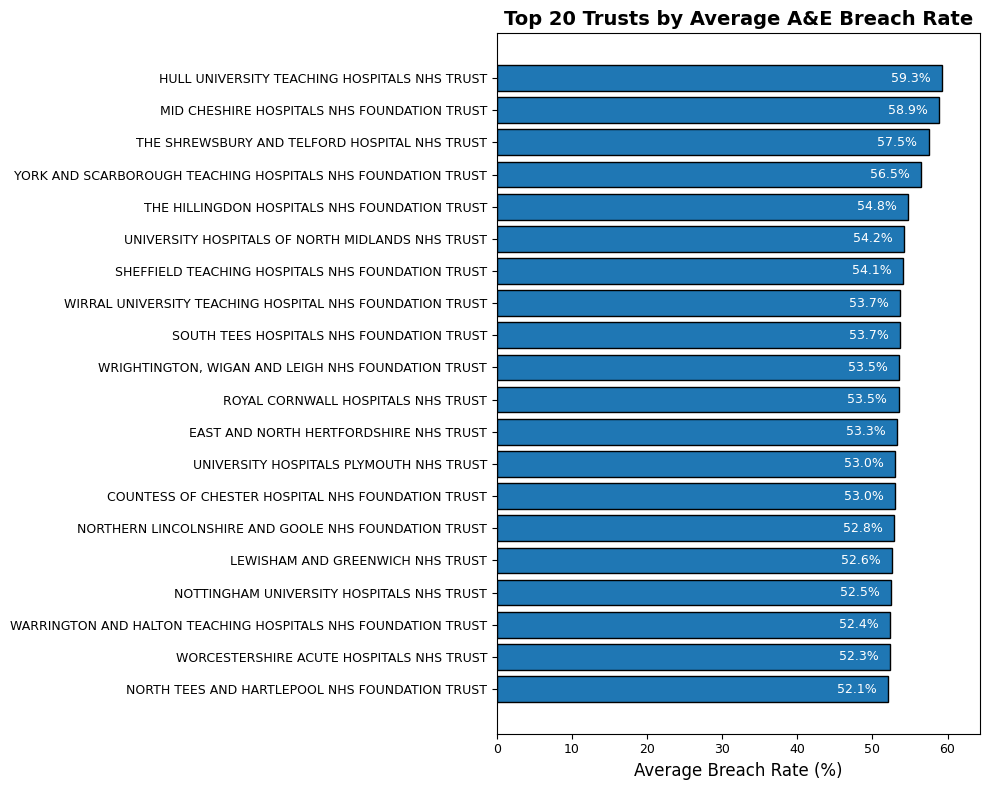

In [0]:
import matplotlib.pyplot as plt

# Sort top 20 by descending breach rate
df_top20 = df_avg_pd.sort_values(by="avg_breach_rate", ascending=False).head(20)

# Set up figure size and style
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.family': 'DejaVu Sans'})

# Plot
bars = plt.barh(
    df_top20["trust"],
    df_top20["avg_breach_rate"],
    color="#1f77b4",  # NHS Blue-ish
    edgecolor="black"
)

# Add value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width - 1.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', ha='right', va='center', color='white', fontsize=9)

# Invert y-axis to show highest breach at the top
plt.gca().invert_yaxis()

# Titles and labels
plt.title("Top 20 Trusts by Average A&E Breach Rate", fontsize=14, weight='bold')
plt.xlabel("Average Breach Rate (%)", fontsize=12)
plt.tight_layout()
plt.xlim(0, max(df_top20["avg_breach_rate"]) + 5)  # keep it inside the right edge
plt.show()


## 📌 Final Summary & Next Steps

This analysis highlighted key breach trends across NHS England’s A&E departments from **Jan–Mar 2025**, using **PySpark** and **NHS public datasets**.

---

### 🔑 Key Takeaways

- Several trusts breached the 4-hour A&E target at **over 50% rates**
- **Hull University** and **Mid Cheshire** consistently ranked among the worst performers
- Region-specific filtering (e.g. `"LONDON"`) helps uncover **localised performance issues**

---

### 🚀 What’s Next?

- Automate this pipeline with **Databricks Jobs** or **Workflows**
- Feed into dashboard tools like **Power BI** or **Tableau**
- Extend to other metrics: **ambulance waits**, **DTA delays**, **emergency admissions**